In [12]:
#########!/apps/anaconda3/bin/python
#for data access, please contact Yuanzhe Ma at ym2865@columbia.edu

from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  RandomizedSearchCV
import pandas as pd
import pickle
from scipy.stats import loguniform
import numpy as np
import datetime
from scipy import optimize
import ast
from params import *
import seaborn as sns
from lightgbm  import LGBMClassifier
import lightgbm
import os
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#from models import model
from sklearn.model_selection import RepeatedStratifiedKFold
import warnings
import csv  
import random as python_random
warnings.filterwarnings("ignore")
from sklearn.calibration import CalibratedClassifierCV
import joblib
  

def set_seed(seed):
    try:
        pass
        #import tensorflow as tf
        #tf.random.set_seed(seed)
    except Exception as e:
        print("Set seed failed,details are ",e)
    try:
        import torch
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
    except Exception as e:
        print("Set seed failed,details are ",e)
        pass
    np.random.seed(seed)
    python_random.seed(seed)


def model_classifier_best(model,best_params_):
    if model=='RFC':
        return RandomForestClassifier(**best_params_)
    elif model=='XGB':
        return XGBClassifier(**best_params_)
    elif model=='LR':
        return LogisticRegression(**best_params_)
    elif model == 'lgb':
        return LGBMClassifier(**best_params_) 
    else:
        pass

model_classifier_dict={'RandomForestClassifier':[RandomForestClassifier(),'RFC'],
                        'XGBClassifier':[XGBClassifier(),'XGB'],
                        'LogisticRegression':[LogisticRegression(),'LR'],
                        'LightGBMClassifier':[LGBMClassifier(),'lgb']
                      }
 
    

parameters_list ={
    'LogisticRegression':
    {
    'solver':['newton-cg', 'lbfgs', 'liblinear'],
    'penalty':['none', 'l1', 'l2', 'elasticnet'],
    'C':loguniform(1e-5, 100)},
    
    'XGBClassifier': 
    {'n_estimators': st.randint(100, 500),
    'learning_rate': st.uniform(0.01, 0.07),
    'subsample': st.uniform(0.7, 0.3),
    'max_depth': [5, 6, 7, 8, 9],
    'colsample_bytree': st.uniform(0.7, 0.3),
    'min_child_weight': st.randint(5, 100),
    'gamma': loguniform(1e-5, 1),
    'reg_lambda': loguniform(1e-5, 100),
    'eval_metric':['logloss']},
    
    'RandomForestClassifier':
    {'n_estimators':  [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features':  ['auto', 'sqrt'],
               'max_depth':  range(5,10),
               'min_samples_split': [2, 5, 11],
               'min_samples_leaf':  [1, 2, 4],
               'bootstrap': [True, False]},
    'LightGBMClassifier':{'num_leaves':[20,40,60,80,100], 
                'n_estimators': st.randint(100, 500),
                'learning_rate': st.uniform(0.01, 0.07),
                'colsample_bytree':st.uniform(0.7, 0.3),
                'subsample':st.uniform(0.7, 0.3),
                'subsample_freq':[1,3],
                'boosting_type':['gbdt','rf'],
                'max_depth':[-1,5,6,7,8,9]
               }
}


 
def model_classifier_train_CV(model_key,x_train,y_train,paras, iter_cnt, random_number, cv_number = 5, njob=10, ver_bose=10):
    classifier_grid_search = RandomizedSearchCV(model_classifier_dict[model_key][0],
                param_distributions = paras, n_iter = iter_cnt, random_state=random_number,
                cv=cv_number, n_jobs=njob,scoring='roc_auc', verbose=ver_bose)
    
    classifier_grid_search.fit(x_train, y_train)
    best_params_= classifier_grid_search.best_params_
   
    classifier_model=model_classifier_best(model_classifier_dict[model_key][1],best_params_)
    
    classifier_model.fit(x_train,y_train) ## retrain on the entire data

    return {'best_cv_score_auc':classifier_grid_search.best_score_,'model':classifier_model,'best_params_':best_params_}



def robustness_estimator_grad(Lambda,y,x):
    '''
    x is the input random observations, Lambda is the parameter we want to find, y is the thresohld
    '''
    exp_labmda_x = np.exp([Lambda*_ for _ in x]) 
    grad = y - np.mean(np.multiply(x,exp_labmda_x)) / np.mean(exp_labmda_x) #formula found in A.5.1 Proof of Lemma 
    return (grad)


def stability_measure(data,threshold): #return the stability measure, input is the data we want to compute and the threshold
    x = data  
    lambda_star = optimize.bisect(robustness_estimator_grad,0, 100,args=(threshold,x), maxiter=100000000,xtol=0.0000001)
    exp_labmda_x = np.exp([lambda_star*_ for _ in x]) 
    stability_measure = lambda_star * threshold - np.log(np.mean(exp_labmda_x)) 
        
    return {'stability_measure':round(stability_measure,5),'mean':round(np.mean(x),5),'std':round(np.std(x),5),'lambda_star':round(lambda_star,14),'threshold':threshold}

# Load Data

In [3]:
df_all  = pd.read_csv('.././Result/stat_data/dataClean.csv')
#for data access, please contact Yuanzhe Ma at ym2865@columbia.edu
df_all = df_all.fillna(0) ##impute missing values
df = {}
for y in range(2008,2019):
    df[y] = df_all[df_all.year==y]
    print(y, df[y].shape)

'''
# eligibility restriction
for yr in range(2008,2019):
df[yr]['meligible'] = 1
df[yr].loc[df_all['ernyr_p'].str[0:2].isin(['10','11'])==True,'meligible'] = 0
df[yr].meligible.value_counts()   
'''
 
    


X_feature = X.copy() 
X_feature = X_feature + ['medicaid_'] #add this variable
Y_feature = 'care_office_2wks'

print(len(X_feature))

2008 (74236, 1131)
2009 (88446, 1131)
2010 (89976, 1131)
2011 (101875, 1131)
2012 (108131, 1131)
2013 (104520, 1131)
2014 (112053, 1131)
2015 (103789, 1131)
2016 (97169, 1131)
2017 (78132, 1131)
2018 (72831, 1131)
397


# Grid Search for different classifiers, save results to a csv

In [ ]:
#train starting from this year
for year_start in [2015]:
    random_seed = 1234
    set_seed(random_seed)
    train, test = train_test_split(df_all[df_all.year == year_start], test_size=0.2, random_state = random_seed) #train using year_start data, split into 80% and 20%
    df[year_start] = test.copy() #df[year_start] will be treated as test data later
    del test

    for model_type in ['LightGBMClassifier','LogisticRegression','RandomForestClassifier']: #,'XGBClassifier'
        model_result = model_classifier_train_CV(model_type,train[X_feature],train[Y_feature] ,parameters_list[model_type], 100, random_seed, cv_number = 5, njob=1, ver_bose=10)

        cv_auc = model_result['best_cv_score_auc']
        test_auc_list = []
        accuracy_list = []


        ##test data on future years
        for y in range(year_start,2019):
            X_test = df[y][X_feature]
            Y_test = np.array(df[y][Y_feature])

            Y_pred = model_result['model'].predict_proba(X_test)[:,1]

            fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred)
            auc = metrics.auc(fpr, tpr)
            test_auc_list.append(auc)

            Y_prediction_value = [1 if item >= 0.5 else 0 for item in Y_pred] #convert prediction to 0/1
            accuracy = 1 - np.mean(np.abs(Y_test - Y_prediction_value))

            accuracy_list.append(accuracy)

        utc_time = datetime.datetime.now()
        str_time = utc_time.strftime("%Y-%m-%d_%H:%M:%S")

        fields=['model_type',model_type,'year_start',str(year_start),'time',str_time,'best_params_',str(model_result['best_params_']),'cv_auc',cv_auc,'test_auc_list',test_auc_list,'accuracy_list',accuracy_list]


        # Store data (serialize)
        with open('/user/ym2865/NHIS/model_file/'+str(model_type)+'_'+str_time+'_'+str(year_start)+'.pkl', 'wb') as handle:
            pickle.dump(model_result['model'], handle, protocol=pickle.HIGHEST_PROTOCOL)


        with open(r'/user/ym2865/NHIS/NHIS_test_result_0604'+str(year_start)+'.csv', 'a') as f:
            writer = csv.writer(f)
            writer.writerow(fields)


# Figure 15 --  auc values across years for different models

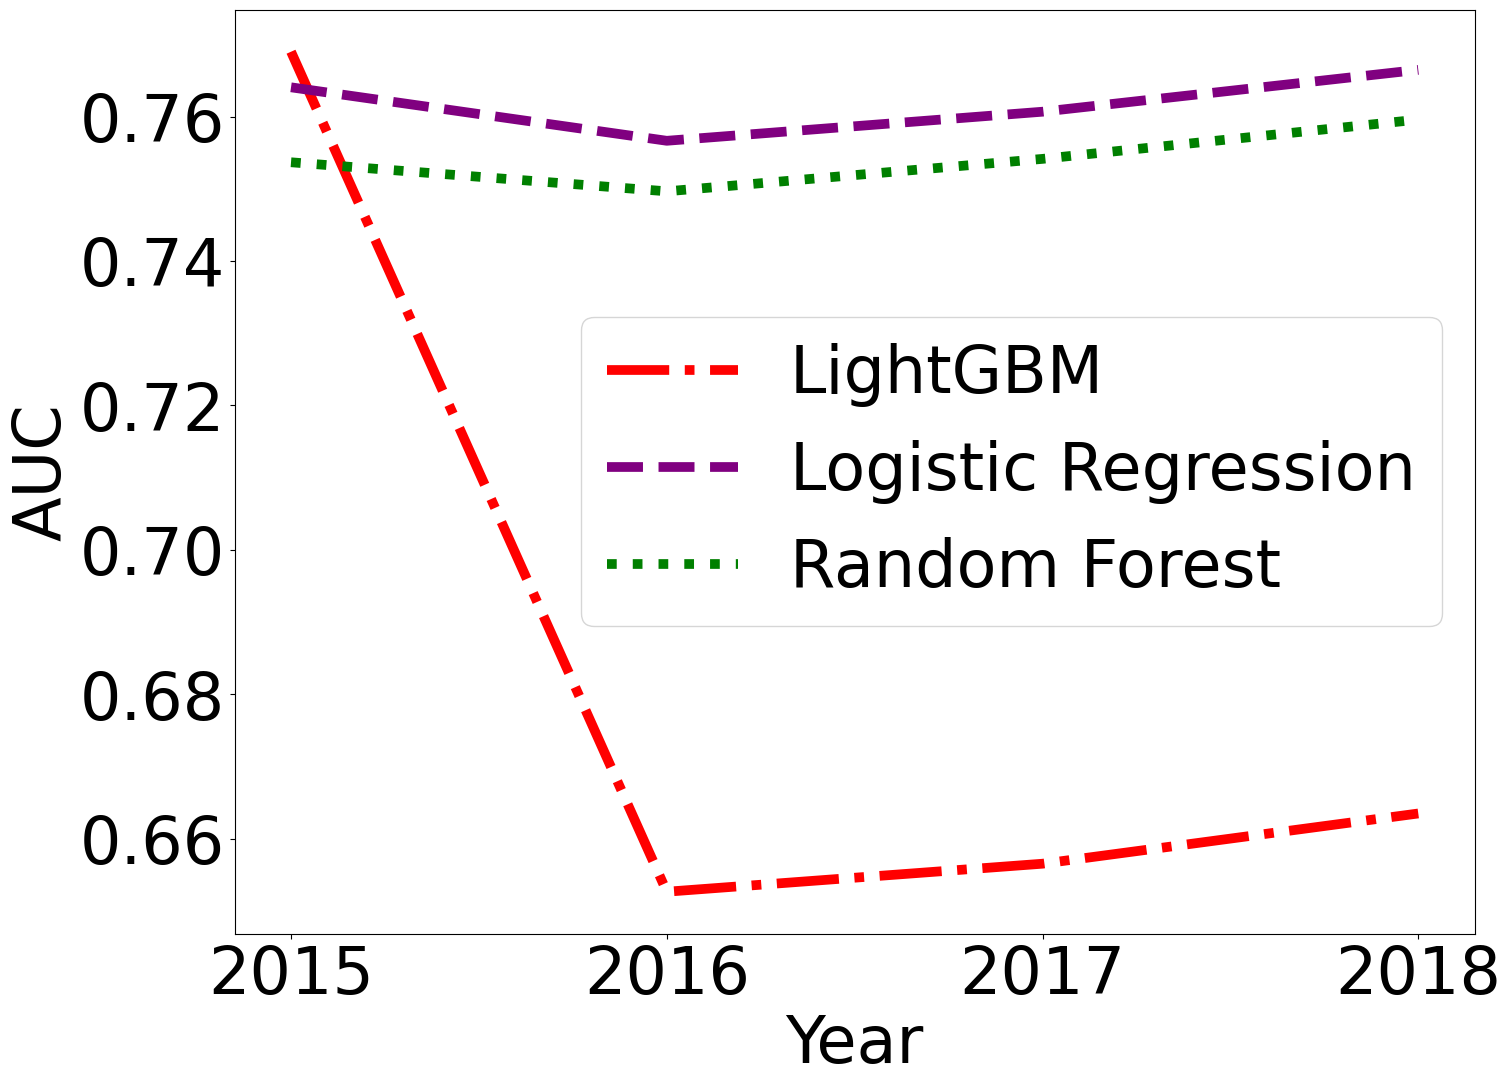

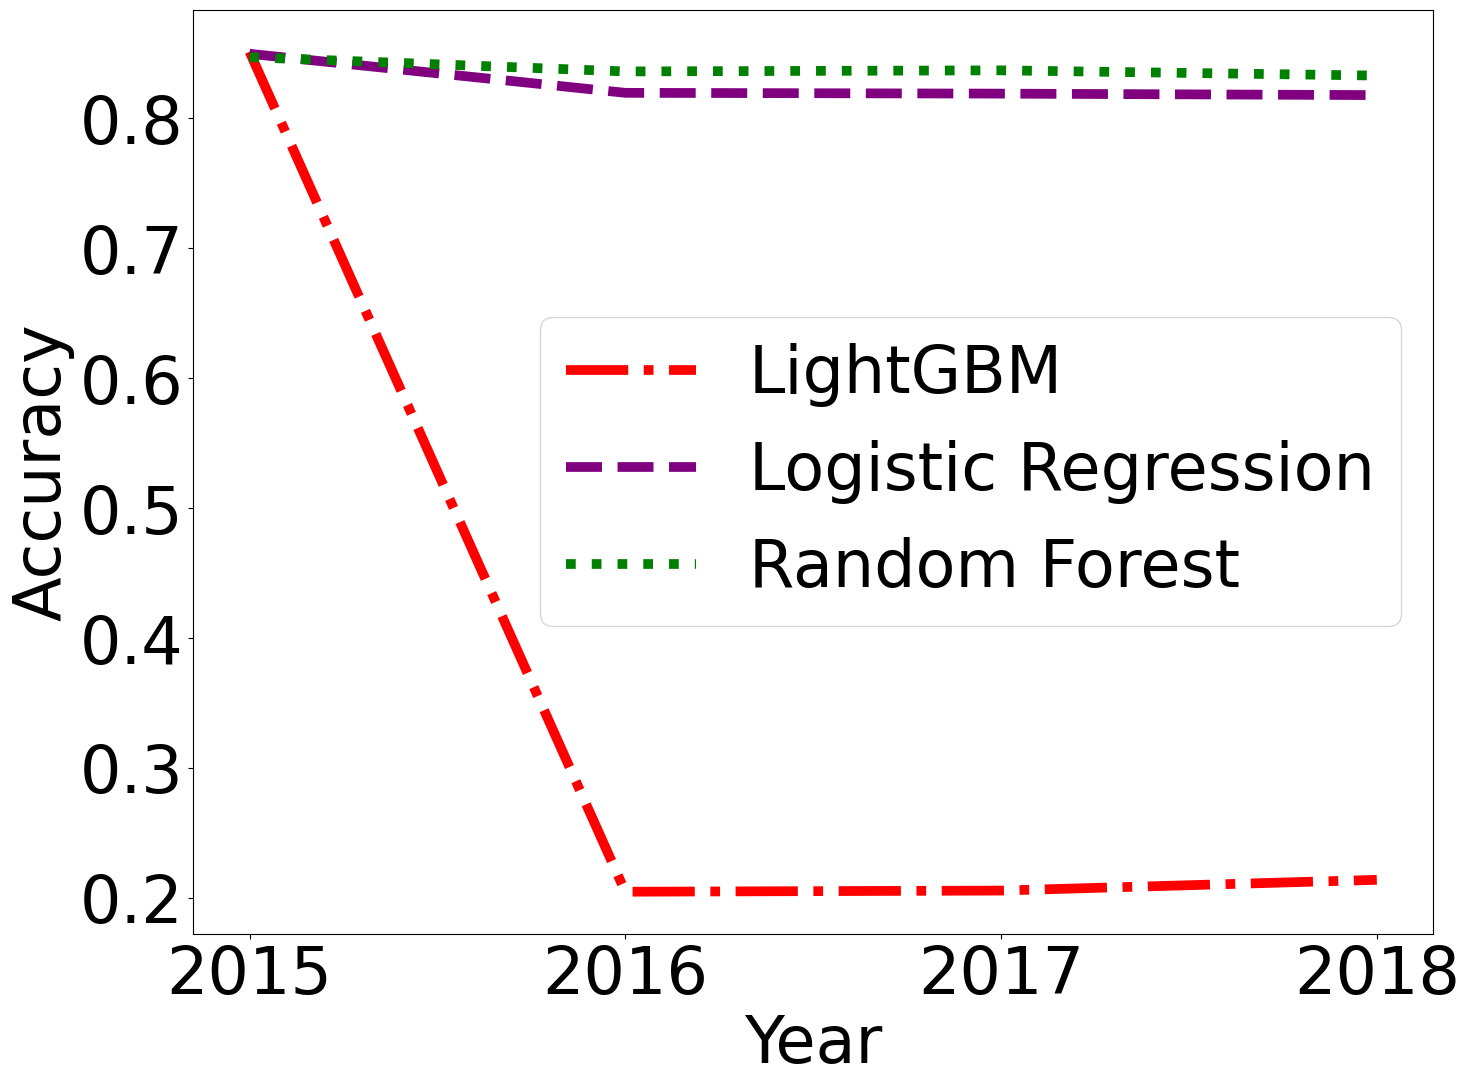

'\nplt\nAUC LightGBMClassifier [0.769, 0.653, 0.657, 0.663]\nAUC LogisticRegression [0.764, 0.757, 0.761, 0.766]\nAUC RandomForestClassifier [0.754, 0.75, 0.754, 0.76]\nAccuracy LightGBMClassifier [0.851, 0.205, 0.206, 0.214]\nAccuracy LogisticRegression [0.85, 0.82, 0.819, 0.818]\nAccuracy RandomForestClassifier [0.847, 0.836, 0.837, 0.833]\n'

In [10]:
### score distribution
plt.figure(figsize=[16, 12])
 

j = 1
 
line_width = 7    
fig_size = 47         
        
linestyle_list = ['-.','--','dotted']
color_list = ['r','purple','green']
for year_start in [2015]:
     
    #linestyle_list=['-','--','dotted','dashdot']


    file_name = '/user/ym2865/NHIS/NHIS_test_result_'+str(year_start)+'.csv'

    i=0
    with open(file_name, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            if row [1] == 'LightGBMClassifier':
                model_type = 'LightGBM'
            elif row [1] == 'RandomForestClassifier':
                model_type = 'Random Forest'
            elif row[1] == 'LogisticRegression':
                model_type = 'Logistic Regression'
                
            auc_list = ast.literal_eval(row[-3])
            x = list(range(year_start,2019))
             
            plt.plot(x,auc_list,label = model_type,linestyle=linestyle_list[i],color = color_list[i], linewidth = line_width) 
            i = i+1 
    
    plt.xticks(x)
            
    plt.xlabel('Year', fontsize=fig_size)
    plt.ylabel('AUC', fontsize=fig_size)
    plt.legend(loc = "center right", prop={'size': fig_size})
    plt.xticks(fontsize=fig_size)
    plt.yticks(fontsize=fig_size)
    
    plt.savefig('/user/ym2865/NHIS/AUC.pdf',format='pdf',dpi=1200,bbox_inches='tight')  
    plt.show()
    
       
    plt.figure(figsize=[16,12])
     
    
    i=0
    with open(file_name, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
             
            if row [1] == 'LightGBMClassifier':
                model_type = 'LightGBM'
            elif row [1] == 'RandomForestClassifier':
                model_type = 'Random Forest'
            elif row[1] == 'LogisticRegression':
                model_type = 'Logistic Regression'
                    
                    
            accuracy_list = ast.literal_eval(row[-1])
            x = list(range(year_start,2019))
            
             
            plt.plot(x,accuracy_list,label = model_type,linestyle=linestyle_list[i],color = color_list[i], linewidth = line_width) 
            i = i+1 

 
    plt.xticks(x)
    plt.xlabel('Year', fontsize=fig_size)
    plt.ylabel('Accuracy', fontsize=fig_size)
    plt.legend(loc = "center right", prop={'size': fig_size})
    plt.xticks(fontsize=fig_size)
    plt.yticks(fontsize=fig_size)
    
    

    plt.savefig('/user/ym2865/NHIS/accuracy.pdf',format='pdf',dpi=1200,bbox_inches='tight')  
    plt.show()
    

 
    
 
 
    
'''
plt
AUC LightGBMClassifier [0.769, 0.653, 0.657, 0.663]
AUC LogisticRegression [0.764, 0.757, 0.761, 0.766]
AUC RandomForestClassifier [0.754, 0.75, 0.754, 0.76]
Accuracy LightGBMClassifier [0.851, 0.205, 0.206, 0.214]
Accuracy LogisticRegression [0.85, 0.82, 0.819, 0.818]
Accuracy RandomForestClassifier [0.847, 0.836, 0.837, 0.833]
'''

# Figure 1 

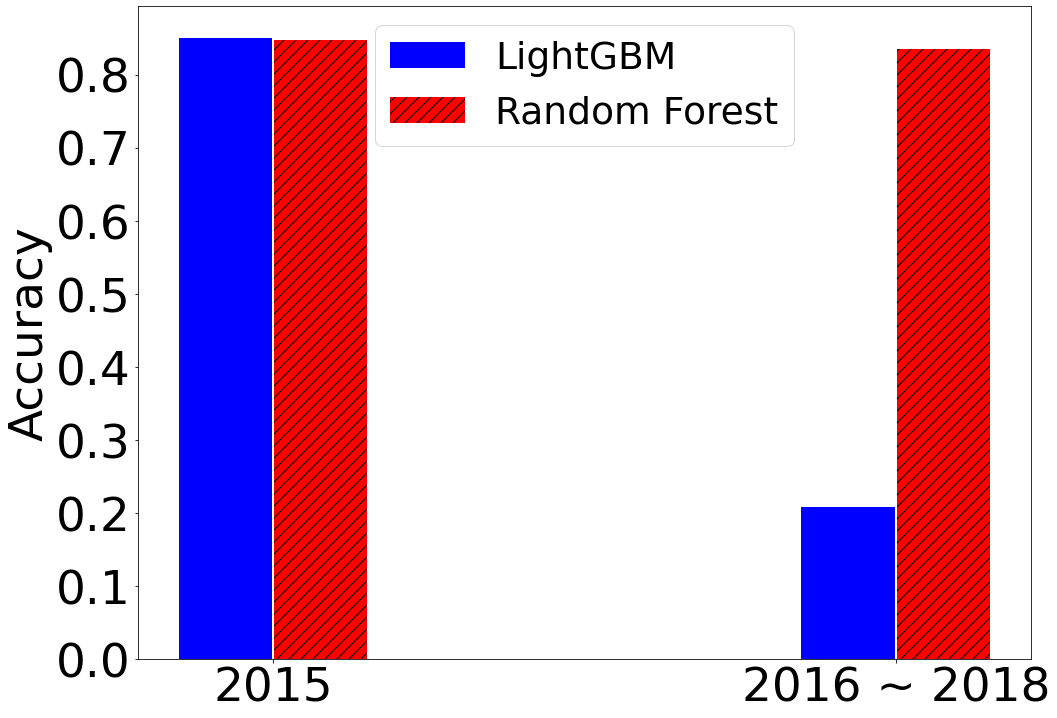

In [17]:
##bar graph version 
fig_size = 47

LightGBMClassifier_acc = [0.851, 0.205, 0.206, 0.214]
RandomForestClassifier_acc = [0.847, 0.836, 0.837, 0.833]

sample_list = [97169,78132,72831]
prop_list =  list(sample_list/np.sum(sample_list))
prop_list = [0] + prop_list

LightGBM_list = [LightGBMClassifier_acc[0]] + [np.sum(np.multiply(prop_list,LightGBMClassifier_acc))] 
RandomForest_list = [RandomForestClassifier_acc[0]]+ [np.sum(np.multiply(prop_list,RandomForestClassifier_acc))]
 

plt.figure(figsize=[16,12])
labels = ['2015','2016 ~ 2018'] 

patterns = [ "" , "//" ]

plt.bar(np.arange(2)-0.077, LightGBM_list,width=0.15, label = 'LightGBM',hatch = patterns[0],color = 'blue')
plt.bar(np.arange(2)+0.076, RandomForest_list,width=0.15, label = 'Random Forest',hatch = patterns[1], color = 'red')
#plt.xlabel('Type of distributional shifts')

plt.legend(prop={'size': 24}) 

plt.xticks([0,1],labels)
#plt.xlabel('Year', fontsize=fig_size)
plt.ylabel('Accuracy', fontsize=fig_size)
plt.legend(loc = 'upper center', prop={'size': fig_size*0.8})
plt.xticks(fontsize=fig_size)
plt.yticks(fontsize=fig_size)
    
plt.savefig('/user/ym2865/NHIS/accuracy_bar_plot.pdf',format='pdf',dpi=1200,bbox_inches='tight')  
plt.show()

In [16]:
Acc_current = [LightGBMClassifier_acc[0]] + [RandomForestClassifier_acc[0]]
Acc_future = [np.sum(np.multiply(prop_list,LightGBMClassifier_acc))] + [np.sum(np.multiply(prop_list,RandomForestClassifier_acc))]
Acc_future

[0.20795653523124785, 0.8354343293085937]

# Generate important features

rf 0.005653830272194187
LR           var     coeff  coeff_abs
342  educ_yrs  0.006395   0.006395


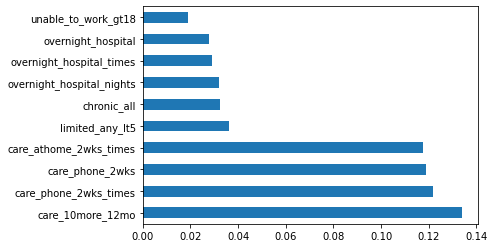

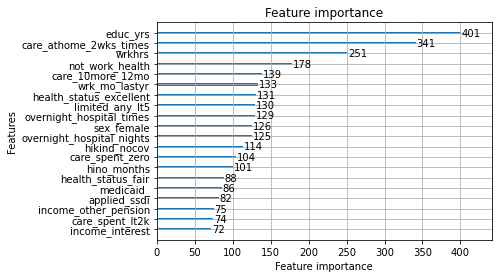

In [7]:
def plotImp(model, features , num = 20, fig_size = (40, 20)):
    feat_importances = pd.Series(model.feature_importances_, index=features)
    feat_importances.nlargest(10).plot(kind='barh')
    return feat_importances
     
rf_feature_importances = plotImp(RandomForestClassifier_model, X_feature)



print('rf',rf_feature_importances['educ_yrs'])


lr_coefficients = pd.concat([pd.DataFrame(X_feature),pd.DataFrame(np.transpose(LogisticRegression_model.coef_))], axis = 1)
lr_coefficients.columns=['var','coeff']
lr_coefficients['coeff_abs'] = np.abs(lr_coefficients['coeff'])
lr_coefficients.sort_values(by='coeff_abs', inplace=True,ascending=False)

print('LR',lr_coefficients[lr_coefficients['var'] == 'educ_yrs'])




lightgbm.plot_importance(LightGBMClassifier_model, max_num_features  = 20)
lightGBM_feature_importances = pd.DataFrame({'Features': X_feature,
                        'Importances': LightGBMClassifier_model.feature_importances_})
lightGBM_feature_importances.sort_values(by='Importances', inplace=True,ascending=False)

# Do stability for conditional expectation of risk, prepare data for Figure 16, also generate stability_data which will be used later

Model training starts 0.21957799402639946


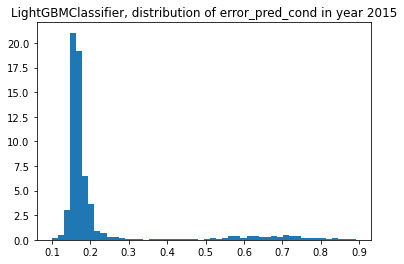

Model training starts 0.1956835918681954


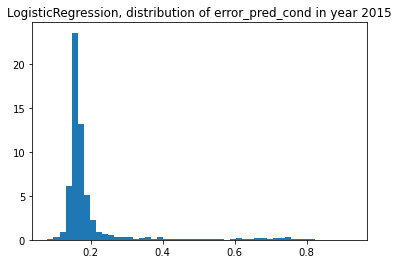

Model training starts 0.20406590230272667


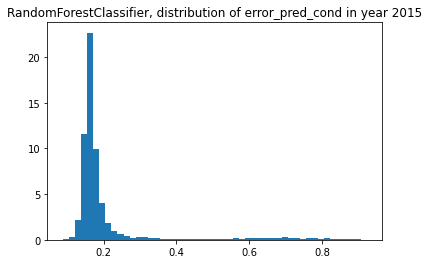

['LightGBMClassifier', 'conditional error rate', {'stability_measure': 0.55827, 'mean': 0.22086, 'std': 0.15361, 'lambda_star': 4.28639350502635, 'threshold': 0.44064000000000003}]
['LogisticRegression', 'conditional error rate', {'stability_measure': 0.89061, 'mean': 0.19647, 'std': 0.1151, 'lambda_star': 5.7646507229947, 'threshold': 0.44064000000000003}]
['RandomForestClassifier', 'conditional error rate', {'stability_measure': 0.73225, 'mean': 0.20387, 'std': 0.1289, 'lambda_star': 4.95529684485518, 'threshold': 0.44064000000000003}]


In [20]:

def auc_computation(Y_test,Y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred)
    auc = metrics.auc(fpr, tpr)
    return auc


def plotImp(model, features , num = 20, fig_size = (40, 20)):
    feat_importances = pd.Series(model.feature_importances_, index=features)
    feat_importances.nlargest(10).plot(kind='barh')
    return feat_importances


with open('/user/ym2865/NHIS/model_file/LightGBMClassifier_2022-04-19_00:05:10_2015.pkl', 'rb') as f:
    LightGBMClassifier_model = pickle.load(f)
with open('/user/ym2865/NHIS/model_file/LogisticRegression_2022-04-19_02:48:55_2015.pkl', 'rb') as f:
    LogisticRegression_model = pickle.load(f)
with open('/user/ym2865/NHIS/model_file/RandomForestClassifier_2022-04-19_10:08:53_2015.pkl', 'rb') as f:
    RandomForestClassifier_model = pickle.load(f)
 

    
model_result ={'LightGBMClassifier':LightGBMClassifier_model ,'LogisticRegression': LogisticRegression_model,'RandomForestClassifier':RandomForestClassifier_model}
stability_measure_list = []
stability_measure_score_list = []
stability_measure_auc_list = []
stability_measure_cross_entropy_list = []
 

Core_variable_list = ['sex_female',
'medicaid_',
#'educ_yrs',
'health_status_excellent',
#'wrkhrs',
'overnight_hospital_times',
'care_athome_2wks_times', #important
'looking_for_work',
'not_work_retired']

Core_variable_list = list(lightGBM_feature_importances['Features'].head(15) )
Core_variable_list = ['educ_yrs',
 'care_athome_2wks_times',
 'wrkhrs',
 'not_work_health',
 'care_10more_12mo',
 'wrk_mo_lastyr',
 'health_status_excellent',
 'limited_any_lt5',
 'overnight_hospital_times',
 'sex_female',
 'overnight_hospital_nights',
 'hikind_nocov',
 'care_spent_zero',
 'hino_months',
 'health_status_fair']


for year_start in [2015]:
    
    set_seed(1234)
    train, test = train_test_split(df_all[df_all.year==year_start], test_size=0.2, random_state = 1234) #train using year_start data, split into 80% and 20%
    df[year_start] = test.copy() #df[year_start] will be treated as test data later
    del test

    for model_type in ['LightGBMClassifier','LogisticRegression','RandomForestClassifier']: #,'XGBClassifier'
        
        score_result = {'2015':0,'2016':0,'2017':0,'2018':0}
        
        test_auc_list = []
        accuracy_list = []

        ##test data on future years
        for y in range(year_start,2019):
            X_test = df[y][X_feature]
            Y_test = np.array(df[y][Y_feature])
            Y_pred = model_result[model_type].predict_proba(X_test)[:,1]
            
            df[y]['model_score'] = Y_pred
                
            fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred)
            auc = metrics.auc(fpr, tpr)
            test_auc_list.append(auc)
            
            split_number = 400
            Y_test_split = np.array_split(Y_test, split_number)
            Y_pred_split = np.array_split(Y_pred, split_number)
            reverse_AUC_split_list = [1 - auc_computation(x,y) for (x,y) in zip(Y_test_split, Y_pred_split)]
            
            if model_type != 'LightGBMClassifier':
                threshold = 0.5
            else:
                threshold = 0.5 #threshold_lightgbm
 
            if y == year_start: #only calculate stability on the test data that has the same year as the training data
              
                test_cond_train, test_cond_test = train_test_split(df[year_start], test_size=0.5, random_state = 1234) 

                cal_rf_iso = CalibratedClassifierCV(model_result[model_type], cv="prefit", method='sigmoid')
                cal_rf_iso.fit(test_cond_train[X_feature], test_cond_train[Y_feature])
                scores_iso = cal_rf_iso.predict_proba(test_cond_test[X_feature])[:, 1]
                 
                Y_test = test_cond_train[Y_feature] #only these y will be used
                
            else: #use full data
                scores_iso = cal_rf_iso.predict_proba(df[y][X_feature])[:, 1] #use previously trained calibriation model
                
            Y_prediction_value = [1 if item >= threshold else 0 for item in scores_iso] #convert prediction to 0/1
            if_wrong = np.abs(Y_test - Y_prediction_value)
             
            utc_time = datetime.datetime.now()
            str_time = utc_time.strftime("%Y-%m-%d_%H:%M:%S")
        
            if y == year_start: #train model #2, further split calibrated probs to 50% 50% training cond. E.
                test_cond_test['if_wrong'] =  np.array(if_wrong)
                second_model_train, second_model_test = train_test_split(test_cond_test, test_size=0.5, random_state = 1234) 
                print('Model training starts', np.mean(if_wrong))
                cond_model_result = model_classifier_train_CV('RandomForestClassifier',second_model_train[Core_variable_list],second_model_train['if_wrong'] ,parameters_list['RandomForestClassifier'], 10, 1234, cv_number = 5, njob=1, ver_bose=0)
                error_pred_cond = cond_model_result['model'].predict_proba(second_model_test[Core_variable_list])[:,1]
                stability_measure_list.append([model_type,'conditional error rate',stability_measure(error_pred_cond,  3*0.14688)])
                
                #Store data (serialize)
                with open('/user/ym2865/NHIS/model_file/'+str(model_type)+'_'+str_time+'_stability_data_'+'.pkl', 'wb') as handle:
                    pickle.dump(error_pred_cond, handle, protocol=pickle.HIGHEST_PROTOCOL)
            else:
                error_pred_cond = cond_model_result['model'].predict_proba(df[y][Core_variable_list])[:,1] #full_data
         
 
            Y_test = list(test_cond_test[Y_feature])
            Y_pred = list(scores_iso)
                        

            accuracy = 1 - np.mean(if_wrong)
            accuracy_list.append(accuracy)
            
            if y == year_start:
                plt.hist(list(error_pred_cond), density=True, bins=50) 
                plt.title(model_type + ', distribution of error_pred_cond in year ' + str(y))
                plt.show()   

            result_temp = {'Y_pred':Y_pred,'Y_test':Y_test}
            score_result[y] = result_temp
            
        #save data 
        with open('/user/ym2865/NHIS/model_file/'+str(model_type)+'_'+str_time+'_score_data_'+'.pkl', 'wb') as handle:
                pickle.dump(score_result, handle, protocol=pickle.HIGHEST_PROTOCOL)
                    
                '''
                    score_0 = [a  for (a,b) in zip(Y_pred,Y_test) if b== 0]
                    score_1 = [a  for (a,b) in zip(Y_pred,Y_test) if b== 1]
                    pyplot.hist(score_0, bins = 50, alpha=0.5, label='score_false_sample')
                    pyplot.hist(score_1, bins = 50, alpha=0.5, label='score_true_sample')
                    pyplot.legend(loc='upper right')
                    pyplot.title(model_type + ', distribution of scores in year ' + str(y))
                    pyplot.show() 

                '''

        
for _ in stability_measure_list:
    print (_)
     

# Figure 16 -- Plot based on pkl file

<Figure size 432x288 with 0 Axes>

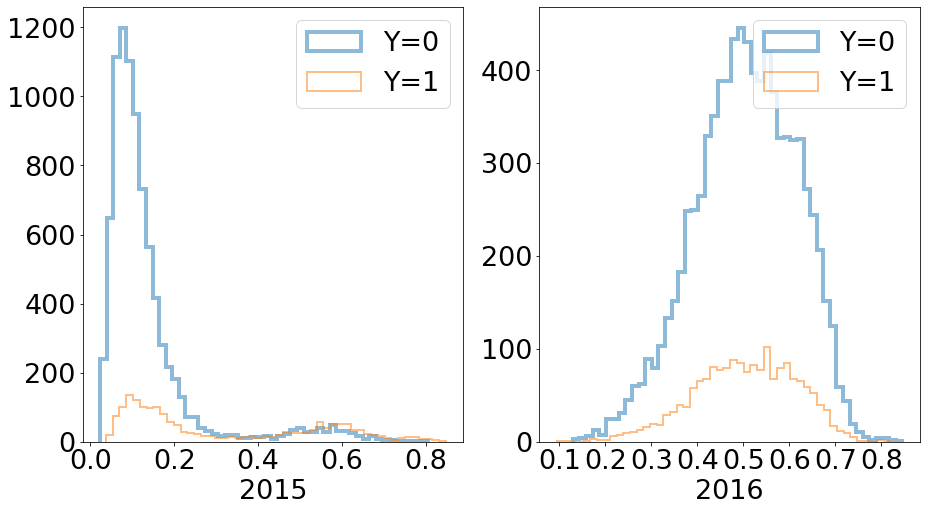

<Figure size 432x288 with 0 Axes>

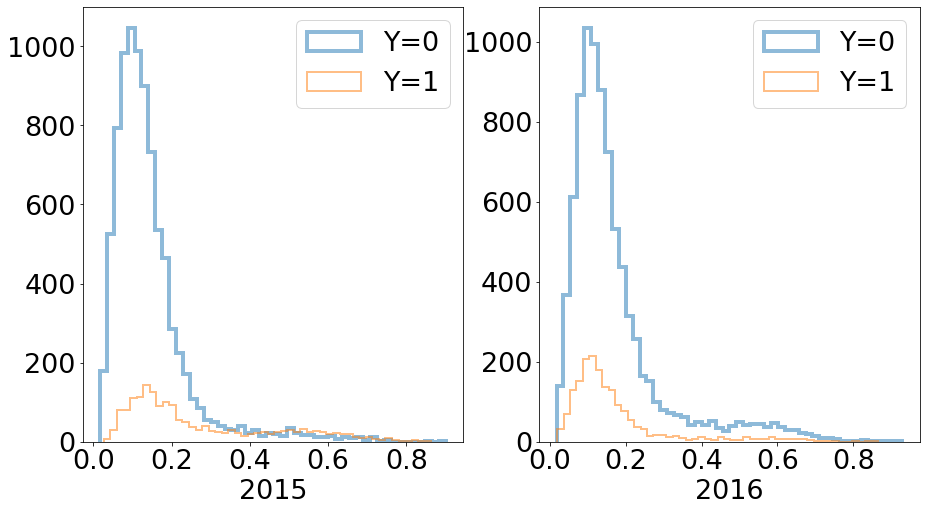

<Figure size 432x288 with 0 Axes>

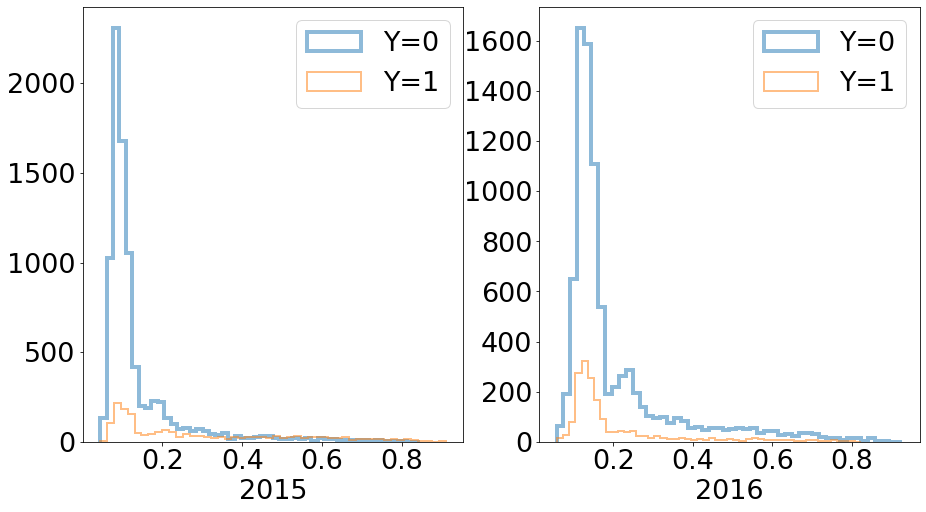

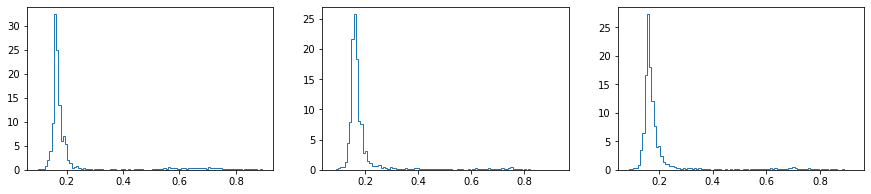

['LightGBMClassifier', 'conditional expectation of error', {'stability_measure': 0.55827, 'mean': 0.22086, 'std': 0.15361, 'lambda_star': 4.28639350502635, 'threshold': 0.44064}]
['LogisticRegression', 'conditional expectation of error', {'stability_measure': 0.89061, 'mean': 0.19647, 'std': 0.1151, 'lambda_star': 5.7646507229947, 'threshold': 0.44064}]
['RandomForestClassifier', 'conditional expectation of error', {'stability_measure': 0.73225, 'mean': 0.20387, 'std': 0.1289, 'lambda_star': 4.95529684485518, 'threshold': 0.44064}]


In [21]:
model_list = ['LightGBMClassifier','LogisticRegression','RandomForestClassifier']
stability_file_list = ['LightGBMClassifier_2023-06-25_23:46:38_stability_data_.pkl'
                       ,'LogisticRegression_2023-06-25_23:50:23_stability_data_.pkl'
                       ,'RandomForestClassifier_2023-06-25_23:53:36_stability_data_.pkl']
score_file_list = ['LightGBMClassifier_2023-06-25_23:50:13_score_data_.pkl'
                   ,'LogisticRegression_2023-06-25_23:53:25_score_data_.pkl'
                   ,'RandomForestClassifier_2023-06-25_23:57:19_score_data_.pkl']       


  

file_path = '/user/ym2865/NHIS/model_file/'
fig_size = 27
line_width = 4

### score distribution
for i in [0,1,2]:
    plt.tight_layout()
    plt.figure(figsize=[15, 8])
    plt.subplots_adjust(hspace=.5)
    j = 1
    model_type = model_list[i]
    score_file = joblib.load(file_path + score_file_list[i])
    for y in [2015,2016]:
        score_data = score_file[y]
        
        plt.subplot(1, 2, j)
        
        
        Y_pred = score_data['Y_pred']
        Y_test = score_data['Y_test']
        score_0 = [a  for (a,b) in zip(Y_pred,Y_test) if b== 0]
        score_1 = [a  for (a,b) in zip(Y_pred,Y_test) if b== 1]
        pyplot.hist(score_0, bins = 50, alpha=0.5, label='Y=0',histtype='step',linewidth = line_width) 
        pyplot.hist(score_1, bins = 50, alpha=0.5, label='Y=1',histtype='step',linewidth = line_width-2) 
        pyplot.legend(loc='upper right', prop={'size': fig_size})
        
      
        pyplot.xlabel(y, fontsize=fig_size)
        pyplot.xticks(fontsize=fig_size)
        pyplot.yticks(fontsize=fig_size)
        j = j + 1

    pyplot.savefig('/user/ym2865/NHIS/'+ model_type +'_distribution.pdf',format='pdf',dpi=1200) #bbox_inches='tight')     
    pyplot.show() 

### score of predicted risk based on core variables
plt.figure(figsize=[15, 3])
stability_measure_list = []


for i in [0,1,2]:
    model_type = model_list[i]
    error_pred_cond = joblib.load(file_path + stability_file_list[i])    
    
    stability_measure_list.append([model_type,'conditional expectation of error',stability_measure(error_pred_cond, 0.44064)])
    
    plt.subplot(1, 3, i+1)
    plt.hist(list(error_pred_cond), density=True, bins=100,histtype='step')
    #plt.xlabel(model_type)
plt.show()   

for _ in stability_measure_list:
    print (_)

# Figure 15, stability for different models 

stability_measure_result {'LightGBMClassifier': [0.05719, 0.0788, 0.10312, 0.12999, 0.15925, 0.19078, 0.22448, 0.26027, 0.29807, 0.33784, 0.37951, 0.42304, 0.46842, 0.5156, 0.56456, 0.61531, 0.66781, 0.72209, 0.77813, 0.83594], 'LogisticRegression': [0.15747, 0.1954, 0.23612, 0.27944, 0.32523, 0.37336, 0.42371, 0.47622, 0.5308, 0.58739, 0.64595, 0.70642, 0.76879, 0.83301, 0.89908, 0.96697, 1.03668, 1.1082, 1.18155, 1.25673], 'RandomForestClassifier': [0.11318, 0.14394, 0.17733, 0.21315, 0.25127, 0.29157, 0.33393, 0.37829, 0.42455, 0.47267, 0.52259, 0.57427, 0.62767, 0.68276, 0.73952, 0.79793, 0.85797, 0.91964, 0.98294, 1.04786]}


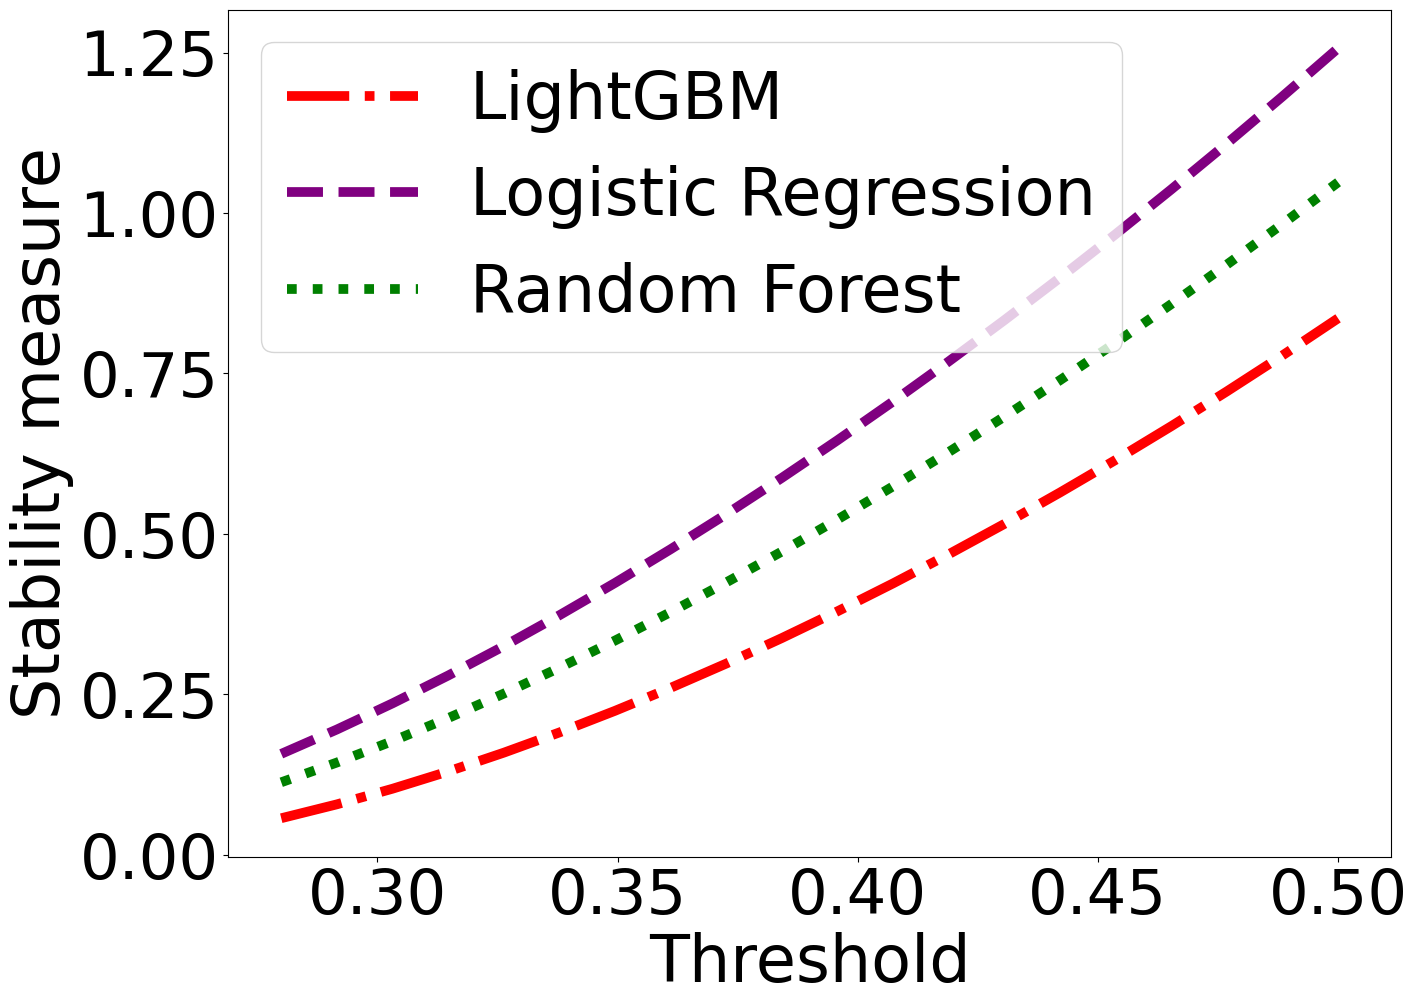

In [17]:
threshold_list = list( np.linspace(0.28, 0.5, 20, endpoint=True))

file_path = '/user/ym2865/NHIS/model_file/'
model_list = ['LightGBMClassifier','LogisticRegression','RandomForestClassifier']
stability_file_list = ['LightGBMClassifier_2023-06-25_23:46:38_stability_data_.pkl'
                       ,'LogisticRegression_2023-06-25_23:50:23_stability_data_.pkl'
                       ,'RandomForestClassifier_2023-06-25_23:53:36_stability_data_.pkl']
error_pred_cond = {}

for i in [0,1,2]:
    model_type = model_list[i]
    error_pred_cond[model_type] = joblib.load(file_path + stability_file_list[i])    
    
    
stability_measure_result = {}
for d in model_list:
    stability_measure_result[d] = []


for threshold in threshold_list:
    for d in model_list:
        #print(stability_measure(error_pred_cond[d],threshold))
        stability_measure_result[d].append(stability_measure(error_pred_cond[d],threshold)['stability_measure'])
 
     
print('stability_measure_result',stability_measure_result)
line_width = 7
fig_size = 47

plt.rcParams["figure.figsize"] = (15,11)

plt.plot(threshold_list, stability_measure_result[model_list[0]],'r',label='LightGBM', linestyle='-.',linewidth = line_width) 
plt.plot(threshold_list, stability_measure_result[model_list[1]],'purple',label='Logistic Regression', linestyle='--',linewidth = line_width) 
plt.plot(threshold_list, stability_measure_result[model_list[2]],'green',label='Random Forest', linestyle='dotted',linewidth = line_width) 
    
plt.xlabel('Threshold', fontsize=fig_size)
plt.ylabel('Stability measure', fontsize=fig_size)
plt.legend(prop={'size': fig_size}) 
plt.tick_params(axis='x', labelsize=fig_size-2)
plt.tick_params(axis='y', labelsize=fig_size-2)
plt.savefig('/user/ym2865/stability/Result/model_data/stability_plot_NHIS.pdf',format='pdf',dpi=1200,bbox_inches='tight')
plt.show()


# Cross entropy loss

In [5]:

def auc_computation(Y_test,Y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred)
    auc = metrics.auc(fpr, tpr)
    return auc


def plotImp(model, features , num = 20, fig_size = (40, 20)):
    feat_importances = pd.Series(model.feature_importances_, index=features)
    feat_importances.nlargest(10).plot(kind='barh')
    return feat_importances


with open('/user/ym2865/NHIS/model_file/LightGBMClassifier_2022-04-19_00:05:10_2015.pkl', 'rb') as f:
    LightGBMClassifier_model = pickle.load(f)
with open('/user/ym2865/NHIS/model_file/LogisticRegression_2022-04-19_02:48:55_2015.pkl', 'rb') as f:
    LogisticRegression_model = pickle.load(f)
with open('/user/ym2865/NHIS/model_file/RandomForestClassifier_2022-04-19_10:08:53_2015.pkl', 'rb') as f:
    RandomForestClassifier_model = pickle.load(f)
 

    
model_result ={'LightGBMClassifier':LightGBMClassifier_model ,'LogisticRegression': LogisticRegression_model,'RandomForestClassifier':RandomForestClassifier_model}
cross_entrop_result ={'LightGBMClassifier':[] ,'LogisticRegression': [],'RandomForestClassifier':[]}

def cross_loss(y,pred):
    if y == 1:
        return -np.log(pred)
    else:
        return -np.log(1-pred)
    
for year_start in [2015]:
    
    set_seed(1234)
    train, test = train_test_split(df_all[df_all.year==year_start], test_size=0.2, random_state = 1234) #train using year_start data, split into 80% and 20%
    df[year_start] = test.copy() #df[year_start] will be treated as test data later
    del test

    for model_type in ['LightGBMClassifier','LogisticRegression','RandomForestClassifier']: #,'XGBClassifier'
        
        score_result = {'2015':0,'2016':0,'2017':0,'2018':0}
        
        test_auc_list = []
        accuracy_list = []

        ##test data on future years
        for y in range(year_start,2019):
            X_test = df[y][X_feature]
            Y_test = np.array(df[y][Y_feature])
            Y_pred = model_result[model_type].predict_proba(X_test)[:,1]
            
            df[y]['model_score'] = Y_pred
            df[y]['cross_entropy'] = 0
            
            if y == year_start:
                cross_entrop_result[model_type] = [cross_loss(y,pred) for (y,pred) in zip(Y_test,Y_pred)]
 

# Save cross entropy loss

In [ ]:
### importance ranking

def auc_computation(Y_test,Y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred)
    auc = metrics.auc(fpr, tpr)
    return auc


def plotImp(model, features , num = 20, fig_size = (40, 20)):
    feat_importances = pd.Series(model.feature_importances_, index=features)
    feat_importances.nlargest(10).plot(kind='barh')
    return feat_importances


with open('/user/ym2865/NHIS/model_file/LightGBMClassifier_2022-04-19_00:05:10_2015.pkl', 'rb') as f:
    LightGBMClassifier_model = pickle.load(f)
with open('/user/ym2865/NHIS/model_file/LogisticRegression_2022-04-19_02:48:55_2015.pkl', 'rb') as f:
    LogisticRegression_model = pickle.load(f)
with open('/user/ym2865/NHIS/model_file/RandomForestClassifier_2022-04-19_10:08:53_2015.pkl', 'rb') as f:
    RandomForestClassifier_model = pickle.load(f)
 

    
model_result ={'LightGBMClassifier':LightGBMClassifier_model ,'LogisticRegression': LogisticRegression_model,'RandomForestClassifier':RandomForestClassifier_model}
stability_measure_list = []
stability_measure_score_list = []
stability_measure_auc_list = []
stability_measure_cross_entropy_list = []
 

Core_variable_list = ['sex_female',
'medicaid_',
#'educ_yrs',
'health_status_excellent',
#'wrkhrs',
'overnight_hospital_times',
'care_athome_2wks_times', #important
'looking_for_work',
'not_work_retired']

Core_variable_list = list(lightGBM_feature_importances['Features'].head(15) )
Core_variable_list = ['educ_yrs',
 'care_athome_2wks_times',
 'wrkhrs',
 'not_work_health',
 'care_10more_12mo',
 'wrk_mo_lastyr',
 'health_status_excellent',
 'limited_any_lt5',
 'overnight_hospital_times',
 'sex_female',
 'overnight_hospital_nights',
 'hikind_nocov',
 'care_spent_zero',
 'hino_months',
 'health_status_fair']


for year_start in [2015]:
    
    set_seed(1234)
    train, test = train_test_split(df_all[df_all.year==year_start], test_size=0.2, random_state = 1234) #train using year_start data, split into 80% and 20%
    df[year_start] = test.copy() #df[year_start] will be treated as test data later
    del test

    for model_type in ['LightGBMClassifier','LogisticRegression','RandomForestClassifier']: #,'XGBClassifier'
        
        score_result = {'2015':0,'2016':0,'2017':0,'2018':0}
        
        test_auc_list = []
        accuracy_list = []

        ##test data on future years
        for y in range(year_start,2019):
            X_test = df[y][X_feature]
            Y_test = np.array(df[y][Y_feature])
            Y_pred = model_result[model_type].predict_proba(X_test)[:,1]
            
            df[y]['model_score'] = Y_pred
            
utc_time = datetime.datetime.now()
str_time = utc_time.strftime("%Y-%m-%d_%H:%M:%S")

model_list = ['LightGBMClassifier','LogisticRegression','RandomForestClassifier']

for model_type in model_list:

    # Store data (serialize)
    with open('/user/ym2865/NHIS/model_file/'+str(model_type)+'_cross_entropy_'+str_time+'_.pkl', 'wb') as handle:
        pickle.dump(cross_entrop_result[model_type], handle, protocol=pickle.HIGHEST_PROTOCOL)

# prepare data for Figure EC.2, plot worst-case exp for cond loss and cross entropy

In [15]:
def worst_case_estimator_grad(alpha,rho,x):
    '''
    x is the input random observations, alpha is the parameter we want to find, rho is the thresohld
    '''
    exp_alpha_x = np.exp([1/alpha*_ for _ in x]) 
    temp_1 = np.log(np.mean(exp_alpha_x)) + rho 
    temp_2 =  np.mean(np.multiply(x,exp_alpha_x)) / np.mean(exp_alpha_x) 
    grad = temp_1 - 1/alpha * temp_2 
    return (grad)


def worst_case_expectation(x,rho): #return the stability measure, input is the data we want to compute and the threshold
    alpha_star = optimize.bisect(worst_case_estimator_grad,0.1, 100000,args=(rho,x), maxiter=100000000,xtol=0.0000001)
    exp_alpha_x = np.exp([1/alpha_star*_ for _ in x]) 
    worst_case_measure =  alpha_star* ( np.log(np.mean(exp_alpha_x)) + rho)
        
    return {'worst_case_measure':round(worst_case_measure,5),'mean':round(np.mean(x),2),'std':round(np.std(x),2),'alpha_star':round(alpha_star,14)}

threshold_list = [0.001,0.002,0.003,0.01,0.02,0.05,0.1,1]
threshold_list = [0.001,0.005,0.01,0.02,0.03,0.04,0.05,0.1,0.2]
threshold_list = [10**(x) for x in [-3,-2.5,-2,-1.5,-1,-0.5,0]]

model_list = ['LightGBMClassifier','LogisticRegression','RandomForestClassifier']
model_name = ['LightGBM','Logistic Regression','Random Forest']

file_path = '/user/ym2865/NHIS/model_file/'
cross_entropy_file_list = ['LightGBMClassifier_cross_entropy_2023-06-26_11:31:54_.pkl'
                       ,'LogisticRegression_cross_entropy_2023-06-26_11:31:54_.pkl'
                       ,'RandomForestClassifier_cross_entropy_2023-06-26_11:31:54_.pkl']
cross_entrop_result = {}

for i, d in enumerate(model_list):
    cross_entrop_result[d] = joblib.load(file_path + cross_entropy_file_list[i])     


worst_case_expectation_result = {}
for d in model_list:
    worst_case_expectation_result[d] = []


for threshold in threshold_list:
    for d in model_list:
        #print(threshold, d)
        worst_case_expectation_result[d].append(worst_case_expectation(cross_entrop_result[d],threshold)['worst_case_measure'])
 
    

# Figure EC.2, plot worst-case exp for cond loss and cross entropy

In [ ]:
line_width = 7
fig_size = 47

plt.rcParams["figure.figsize"] = (15,11)

sub_sample = [0,1,2,3,4,5]

def f(x,s):
    return x
    #return np.array(x)[s]

marker_size = 24

linestyle_list = ['-.','--','dotted']
color_list = ['r','purple','green']
model_name = ['LightGBM','Logistic Regression','Random Forest']

fig, ax = plt.subplots(1, 1)

for j,d in enumerate(model_list): 
    ax.plot(threshold_list,worst_case_expectation_result[d],color_list[j]
             ,marker = '.', markersize = marker_size,
             label = model_name[j], linestyle = linestyle_list[j], linewidth = 7)

    
ax.set_xlabel(r'$\rho$', fontsize=fig_size)
ax.set_ylabel('Worst-case loss', fontsize=fig_size)
ax.legend(prop={'size': fig_size}) 
ax.tick_params(axis='x', labelsize=fig_size-2)
ax.tick_params(axis='y', labelsize=fig_size-2)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xticks(threshold_list)
#ax.set_yticks([0.1,0.5,1,10])

plt.savefig('/user/ym2865/Result/model_data/worst_case_expectation_plot_NHIS_data_cross_entropy.pdf',format='pdf',dpi=1200,bbox_inches='tight')
#plt.savefig('/user/ym2865/Result/model_data/worst_case_expectation_plot_NHIS_data_conditial_risk.pdf',format='pdf',dpi=1200,bbox_inches='tight')

plt.show() 

# prepare data for Figure EC.4, plot worst-case exp for conditional loss

In [ ]:
##worst case for cond. risk
def worst_case_estimator_grad(alpha,rho,x):
    '''
    x is the input random observations, alpha is the parameter we want to find, rho is the thresohld
    '''
    exp_alpha_x = np.exp([1/alpha*_ for _ in x]) 
    temp_1 = np.log(np.mean(exp_alpha_x)) + rho 
    temp_2 =  np.mean(np.multiply(x,exp_alpha_x)) / np.mean(exp_alpha_x) 
    grad = temp_1 - 1/alpha * temp_2 
    return (grad)


def worst_case_expectation(x,rho): #return the stability measure, input is the data we want to compute and the threshold
    alpha_star = optimize.bisect(worst_case_estimator_grad,0.1, 100000,args=(rho,x), maxiter=100000000,xtol=0.0000001)
    exp_alpha_x = np.exp([1/alpha_star*_ for _ in x]) 
    worst_case_measure =  alpha_star* ( np.log(np.mean(exp_alpha_x)) + rho)
        
    return {'worst_case_measure':round(worst_case_measure,5),'mean':round(np.mean(x),2),'std':round(np.std(x),2),'alpha_star':round(alpha_star,14)}


file_path = '/user/ym2865/NHIS/model_file/'
model_list = ['LightGBMClassifier','LogisticRegression','RandomForestClassifier']
stability_file_list = ['LightGBMClassifier_2023-06-25_23:46:38_stability_data_.pkl'
                       ,'LogisticRegression_2023-06-25_23:50:23_stability_data_.pkl'
                       ,'RandomForestClassifier_2023-06-25_23:53:36_stability_data_.pkl']
error_pred_cond = {}

for i in [0,1,2]:
    model_type = model_list[i]
    error_pred_cond[model_type] = joblib.load(file_path + stability_file_list[i])    
    
threshold_list = [0.001,0.005,0.01,0.02,0.03,0.04,0.05,0.1]
threshold_list = [10**(x) for x in [-3,-2.5,-2,-1.5,-1,-0.5,0]]
    
worst_case_expectation_result = {}
for d in model_list:
    worst_case_expectation_result[d] = []


for threshold in threshold_list:
    for d in model_list:
        #print(threshold, d)
        worst_case_expectation_result[d].append(worst_case_expectation(error_pred_cond[d],threshold)['worst_case_measure'])
     

# Figure EC.4, plot worst-case exp for conditional loss

In [ ]:
line_width = 7
fig_size = 47

plt.rcParams["figure.figsize"] = (15,11)

sub_sample = [0,1,2,3,4,5]

def f(x,s):
    return x
    #return np.array(x)[s]

marker_size = 24

linestyle_list = ['-.','--','dotted']
color_list = ['r','purple','green']
model_name = ['LightGBM','Logistic Regression','Random Forest']

fig, ax = plt.subplots(1, 1)

for j,d in enumerate(model_list): 
    ax.plot(threshold_list,worst_case_expectation_result[d],color_list[j]
             ,marker = '.', markersize = marker_size,
             label = model_name[j], linestyle = linestyle_list[j], linewidth = 7)

    
ax.set_xlabel(r'$\rho$', fontsize=fig_size)
ax.set_ylabel('Worst-case loss', fontsize=fig_size)
ax.legend(prop={'size': fig_size}) 
ax.tick_params(axis='x', labelsize=fig_size-2)
ax.tick_params(axis='y', labelsize=fig_size-2)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xticks(threshold_list)
#ax.set_yticks([0.1,0.5,1,10])

plt.savefig('/user/ym2865/Result/model_data/worst_case_expectation_plot_NHIS_data_conditial_risk.pdf',format='pdf',dpi=1200,bbox_inches='tight')

plt.show() 

# Figure EC.1 , CVaR for Cross Entropy

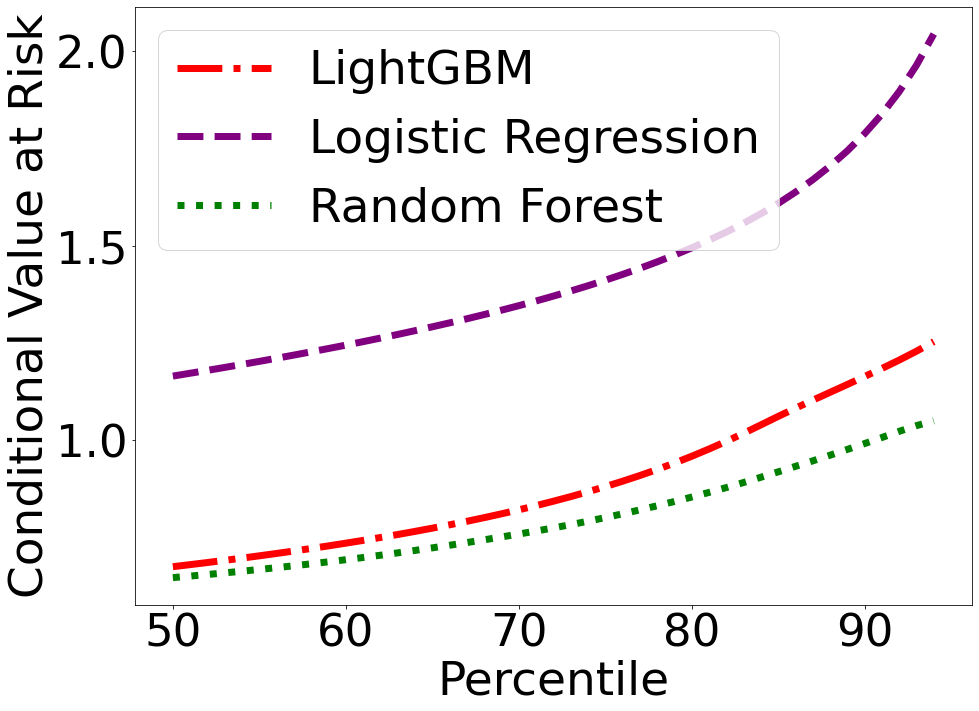

In [8]:
#threshold_list = list( np.linspace(0.28, 0.5, 20, endpoint=True))
import joblib

file_path = '/user/ym2865/NHIS/model_file/'
model_list = ['LightGBMClassifier','LogisticRegression','RandomForestClassifier']
stability_file_list = ['LightGBMClassifier_2023-06-25_23:46:38_stability_data_.pkl'
                       ,'LogisticRegression_2023-06-25_23:50:23_stability_data_.pkl'
                       ,'RandomForestClassifier_2023-06-25_23:53:36_stability_data_.pkl']

cross_entropy_file_list = ['LightGBMClassifier_cross_entropy_2023-06-26_11:31:54_.pkl'
                       ,'LogisticRegression_cross_entropy_2023-06-26_11:31:54_.pkl'
                       ,'RandomForestClassifier_cross_entropy_2023-06-26_11:31:54_.pkl']

model_name = ['LightGBM','Logistic Regression','Random Forest']

error_pred_cond = {}
cross_entrop_result = {}

for i in range(3):
    model_type = model_list[i]
    error_pred_cond[model_type] = joblib.load(file_path + stability_file_list[i])  
    cross_entrop_result[model_type] = joblib.load(file_path + cross_entropy_file_list[i])     

linestyle_list = ['-.','--','dotted']
color_list = ['r','purple','green']

# plt.plot(threshold_list, stability_measure_result[model_list[0]],'r',label='LightGBM', linestyle='-.',linewidth = line_width) 
# plt.plot(threshold_list, stability_measure_result[model_list[1]],'purple',label='Logistic Regression', linestyle='--',linewidth = line_width) 
# plt.plot(threshold_list, stability_measure_result[model_list[2]],'green',label='Random Forest', linestyle='dotted',linewidth = line_width) 
    
    


error_pred_cond = {}
cross_entrop_result = {}

for i in [0,1,2]:
    model_type = model_list[i]
    error_pred_cond[model_type] = joblib.load(file_path + stability_file_list[i])  
    cross_entrop_result[model_type] = joblib.load(file_path + cross_entropy_file_list[i]) 
    
percentile_list = range(50,95)  


line_width = 7
fig_size = 47

plt.rcParams["figure.figsize"] = (15,11)

for j,d in enumerate(model_list):
    result = []
    #X = [_ for _ in error_pred_cond[d]]
    X = cross_entrop_result[d]
    for i in percentile_list:
        var = np.percentile(X,i)
        cvar = [_ for _ in X if _ >= var]
        result.append(np.mean(cvar))
    plt.plot(percentile_list,result,color_list[j],label = model_name[j], linestyle = linestyle_list[j], linewidth = 7)

plt.xlabel('Percentile', fontsize=fig_size)
plt.ylabel(r'Conditional Value at Risk', fontsize=fig_size)
plt.legend(prop={'size': fig_size}) 
plt.tick_params(axis='x', labelsize=fig_size-2)
plt.tick_params(axis='y', labelsize=fig_size-2)


plt.savefig('/user/ym2865/Result/model_data/NHIS_CVaR.pdf',format='pdf',dpi=1200,bbox_inches='tight')
plt.show()


# Figure EC.3, CVaR for cond loss

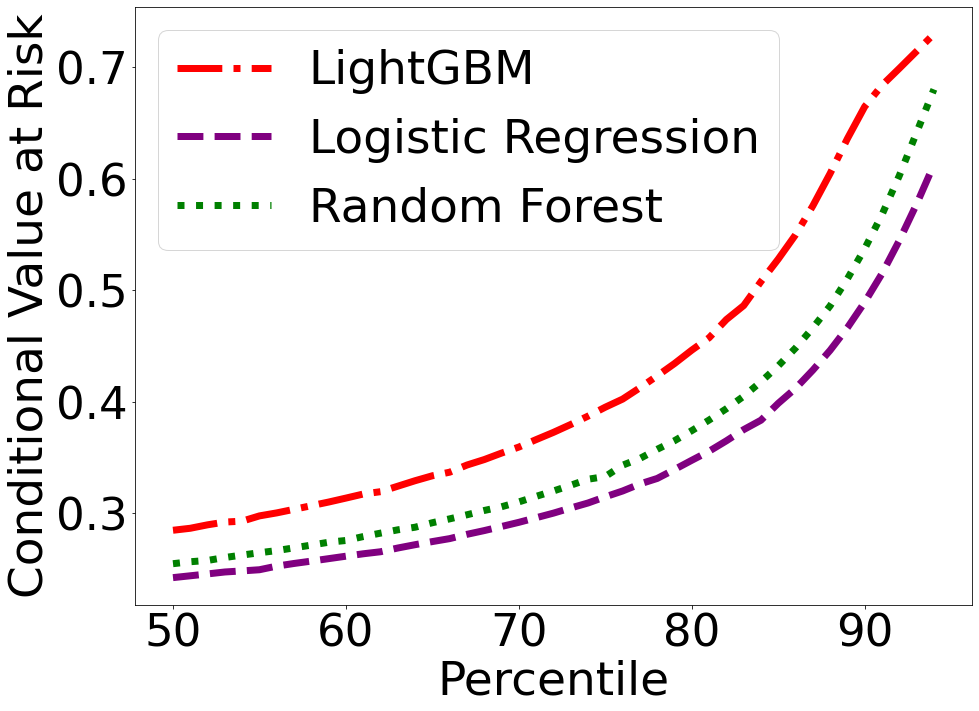

In [9]:
#threshold_list = list( np.linspace(0.28, 0.5, 20, endpoint=True))
import joblib

file_path = '/user/ym2865/NHIS/model_file/'
model_list = ['LightGBMClassifier','LogisticRegression','RandomForestClassifier']
stability_file_list = ['LightGBMClassifier_2023-06-25_23:46:38_stability_data_.pkl'
                       ,'LogisticRegression_2023-06-25_23:50:23_stability_data_.pkl'
                       ,'RandomForestClassifier_2023-06-25_23:53:36_stability_data_.pkl']

 
error_pred_cond = {}
cross_entrop_result = {}

for i in range(3):
    model_type = model_list[i]
    error_pred_cond[model_type] = joblib.load(file_path + stability_file_list[i])  

linestyle_list = ['-.','--','dotted']
color_list = ['r','purple','green']

# plt.plot(threshold_list, stability_measure_result[model_list[0]],'r',label='LightGBM', linestyle='-.',linewidth = line_width) 
# plt.plot(threshold_list, stability_measure_result[model_list[1]],'purple',label='Logistic Regression', linestyle='--',linewidth = line_width) 
# plt.plot(threshold_list, stability_measure_result[model_list[2]],'green',label='Random Forest', linestyle='dotted',linewidth = line_width) 
    
    


error_pred_cond = {}
cross_entrop_result = {}

for i in [0,1,2]:
    model_type = model_list[i]
    error_pred_cond[model_type] = joblib.load(file_path + stability_file_list[i])  
    
percentile_list = range(50,95)  


line_width = 7
fig_size = 47

plt.rcParams["figure.figsize"] = (15,11)

for j,d in enumerate(model_list):
    result = []
    #X = [_ for _ in error_pred_cond[d]]
    X = error_pred_cond[d]
    for i in percentile_list:
        var = np.percentile(X,i)
        cvar = [_ for _ in X if _ >= var]
        result.append(np.mean(cvar))
    plt.plot(percentile_list,result,color_list[j],label = model_name[j], linestyle = linestyle_list[j], linewidth = 7)

plt.xlabel('Percentile', fontsize=fig_size)
plt.ylabel(r'Conditional Value at Risk', fontsize=fig_size)
plt.legend(prop={'size': fig_size}) 
plt.tick_params(axis='x', labelsize=fig_size-2)
plt.tick_params(axis='y', labelsize=fig_size-2)


plt.savefig('/user/ym2865/Result/model_data/NHIS_CVaR_cond_risk.pdf',format='pdf',dpi=1200,bbox_inches='tight')
plt.show()